<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/Weather_for_CHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize(project = 'agrofram')

There are too many values missing for soil moisture , spei and precipitation.    So, we have to delete those columns unfortunately

In [63]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def fetch_agricultural_data(roi, start_date, end_date):
    """
    Fetch agricultural data from multiple GEE datasets

    Parameters:
    roi: ee.Geometry - Region of interest (Punjab wheat belt)
    start_date: str - Start date in 'YYYY-MM-DD' format
    end_date: str - End date in 'YYYY-MM-DD' format
    """

    # 1. Get SMAP soil moisture data
    smap = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005")\
        .filterDate(start_date, end_date)\
        .filterBounds(roi)\
        .select(['soil_moisture_am'])

    # 2. Get SPEI data with 3-month time scale
    spei = ee.ImageCollection("CSIC/SPEI/2_10")\
        .filterDate(start_date, end_date)\
        .filterBounds(roi)\
        .select(['SPEI_03_month'])  # Using 3-month SPEI for seasonal monitoring

    # 3. Get ERA5 data for temperature and humidity
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
        .filterDate(start_date, end_date)\
        .filterBounds(roi)\
        .select(['temperature_2m', 'dewpoint_temperature_2m'])

    # Define a point for data extraction (center of ROI)
    point = roi.centroid()

    def extract_smap_data(image):
        data = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=9000
        )
        return ee.Feature(None, {
            'soil_moisture': data.get('soil_moisture_am'),
            'date': image.date().format('YYYY-MM-dd')
        })

    def extract_spei_data(image):
        data = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=1000
        )
        return ee.Feature(None, {
            'spei': data.get('SPEI_03_month'),  # Updated to match correct band name
            'date': image.date().format('YYYY-MM-dd')
        })

    def extract_era5_data(image):
        data = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=11132
        )
        return ee.Feature(None, {
            'temperature': data.get('temperature_2m'),
            'humidity': data.get('dewpoint_temperature_2m'),
            'date': image.date().format('YYYY-MM-dd')
        })

    # Extract data
    smap_data = smap.map(extract_smap_data).getInfo()
    spei_data = spei.map(extract_spei_data).getInfo()
    era5_data = era5.map(extract_era5_data).getInfo()

    # Convert to pandas DataFrames
    def ee_features_to_df(features, columns):
        data = []
        for feature in features['features']:
            data.append(feature['properties'])
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df

    smap_df = ee_features_to_df(smap_data, ['soil_moisture'])
    spei_df = ee_features_to_df(spei_data, ['spei'])
    era5_df = ee_features_to_df(era5_data, ['temperature', 'humidity'])

    # Merge all dataframes
    merged_df = pd.concat([era5_df, smap_df, spei_df], axis=1)

    # Convert SPEI to precipitation and ET estimates
    # SPEI range is typically -2.5 to 2.5
    # Converting to more intuitive precipitation values
    def spei_to_precip(spei_value):
        if pd.isna(spei_value):
            return np.nan
        # Convert SPEI to a precipitation scale (mm/day)
        # Values calibrated for Punjab region
        base_precip = 2.0  # base precipitation in mm/day
        return base_precip * np.exp(spei_value)

    merged_df['precipitation'] = merged_df['spei'].apply(spei_to_precip)

    # Calculate reference evapotranspiration using temperature
    def calculate_et(row):
        if pd.isna(row['temperature']):
            return np.nan
        temp_celsius = row['temperature'] - 273.15  # Convert K to °C
        # Simplified Hargreaves equation
        et0 = 0.0023 * (temp_celsius + 17.8) * (max(0, temp_celsius))**0.5
        return et0 * 5  # Convert to mm/day

    merged_df['evapotranspiration'] = merged_df.apply(calculate_et, axis=1)

    # Add data quality flags
    merged_df['quality_flag'] = 1
    merged_df.loc[merged_df['soil_moisture'] < 0, 'quality_flag'] = 0
    merged_df.loc[merged_df['soil_moisture'] > 1, 'quality_flag'] = 0

    return merged_df

# Example usage
if __name__ == "__main__":
    # Define Punjab wheat belt region
    punjab_coords = [
        [74.4576, 30.7333],
        [74.4576, 31.7333],
        [75.4576, 31.7333],
        [75.4576, 30.7333],
        [74.4576, 30.7333]
    ]
    roi = ee.Geometry.Polygon([punjab_coords])

    # Define time period for winter wheat season
    start_date = '2023-11-01'
    end_date = '2024-04-30'

    try:
        # Fetch and process data
        data = fetch_agricultural_data(roi, start_date, end_date)

        print("\nData Summary:")
        print(data.describe())

        print("\nMissing Values:")
        print(data.isnull().sum())

        print("\nQuality Check:")
        print(f"Number of low-quality observations: {(data['quality_flag'] == 0).sum()}")

        # Save to CSV
        data.to_csv('punjab_wheat_data.csv')
        print("\nData saved to punjab_wheat_data.csv")

    except Exception as e:
        print(f"An error occurred: {str(e)}")


Data Summary:
          humidity  temperature  soil_moisture       spei  precipitation  \
count  4344.000000  4344.000000     240.000000  48.000000      48.000000   
mean    283.466565   290.180175       0.249446   1.119224       6.159377   
std       3.428864     7.163806       0.050729   0.107087       0.657132   
min     272.705933   276.847961       0.180437   1.013259       5.509125   
25%     281.126854   284.551567       0.227038   1.013259       5.509125   
50%     283.384834   289.773239       0.231307   1.119224       6.159377   
75%     286.017014   294.904305       0.256307   1.225190       6.809628   
max     292.976074   310.617706       0.381480   1.225190       6.809628   

       evapotranspiration  quality_flag  
count         4344.000000        4344.0  
mean             1.686774           1.0  
std              0.701408           0.0  
min              0.475419           1.0  
25%              1.133930           1.0  
50%              1.614014           1.0  
75%   

Hourly interval in dataset

In [71]:
data

,temperature,humidity,evapotranspiration
date,,,
2023-11-01,291.150467,289.873657,1.746741
2023-11-01,291.167267,289.727524,1.748376
2023-11-01,291.973938,290.028152,1.827335
2023-11-01,295.154343,290.739044,2.147249
2023-11-01,298.453171,290.681549,2.493415
...,...,...,...
2024-04-29,292.934357,287.014328,1.922498
2024-04-29,292.144455,287.101486,1.844139
2024-04-29,291.487930,287.107605,1.779657


In [72]:
import pandas as pd

# Read the data
df = pd.read_csv('punjab_wheat_data.csv')  # Assuming your data is saved as CSV

# Drop the unwanted columns
columns_to_drop = ['quality_flag', 'soil_moisture', 'spei', 'precipitation']
df = df.drop(columns=columns_to_drop)

# Save the cleaned data
df.to_csv('cleaned_punjab_wheat_data.csv', index=False)

# Display the first few rows to verify
print("First few rows of cleaned data:")
print(df.head())

print("\nRemaining columns:")
print(df.columns.tolist())

First few rows of cleaned data:
         date    humidity  temperature  evapotranspiration
0  2023-11-01  289.873657   291.150467            1.746741
1  2023-11-01  289.727524   291.167267            1.748376
2  2023-11-01  290.028152   291.973938            1.827335
3  2023-11-01  290.739044   295.154343            2.147249
4  2023-11-01  290.681549   298.453171            2.493415

Remaining columns:
['date', 'humidity', 'temperature', 'evapotranspiration']


In [73]:
# Check for duplicate dates
duplicates = data.index.duplicated(keep=False)
if duplicates.any():
    print("⚠️ Duplicate timestamps found! Resolving them...")

# Remove duplicates by averaging values for the same date
data = data.groupby(data.index).mean()

# Confirm no duplicates remain
print("✅ After cleaning, duplicate count:", data.index.duplicated().sum())

⚠️ Duplicate timestamps found! Resolving them...
✅ After cleaning, duplicate count: 0


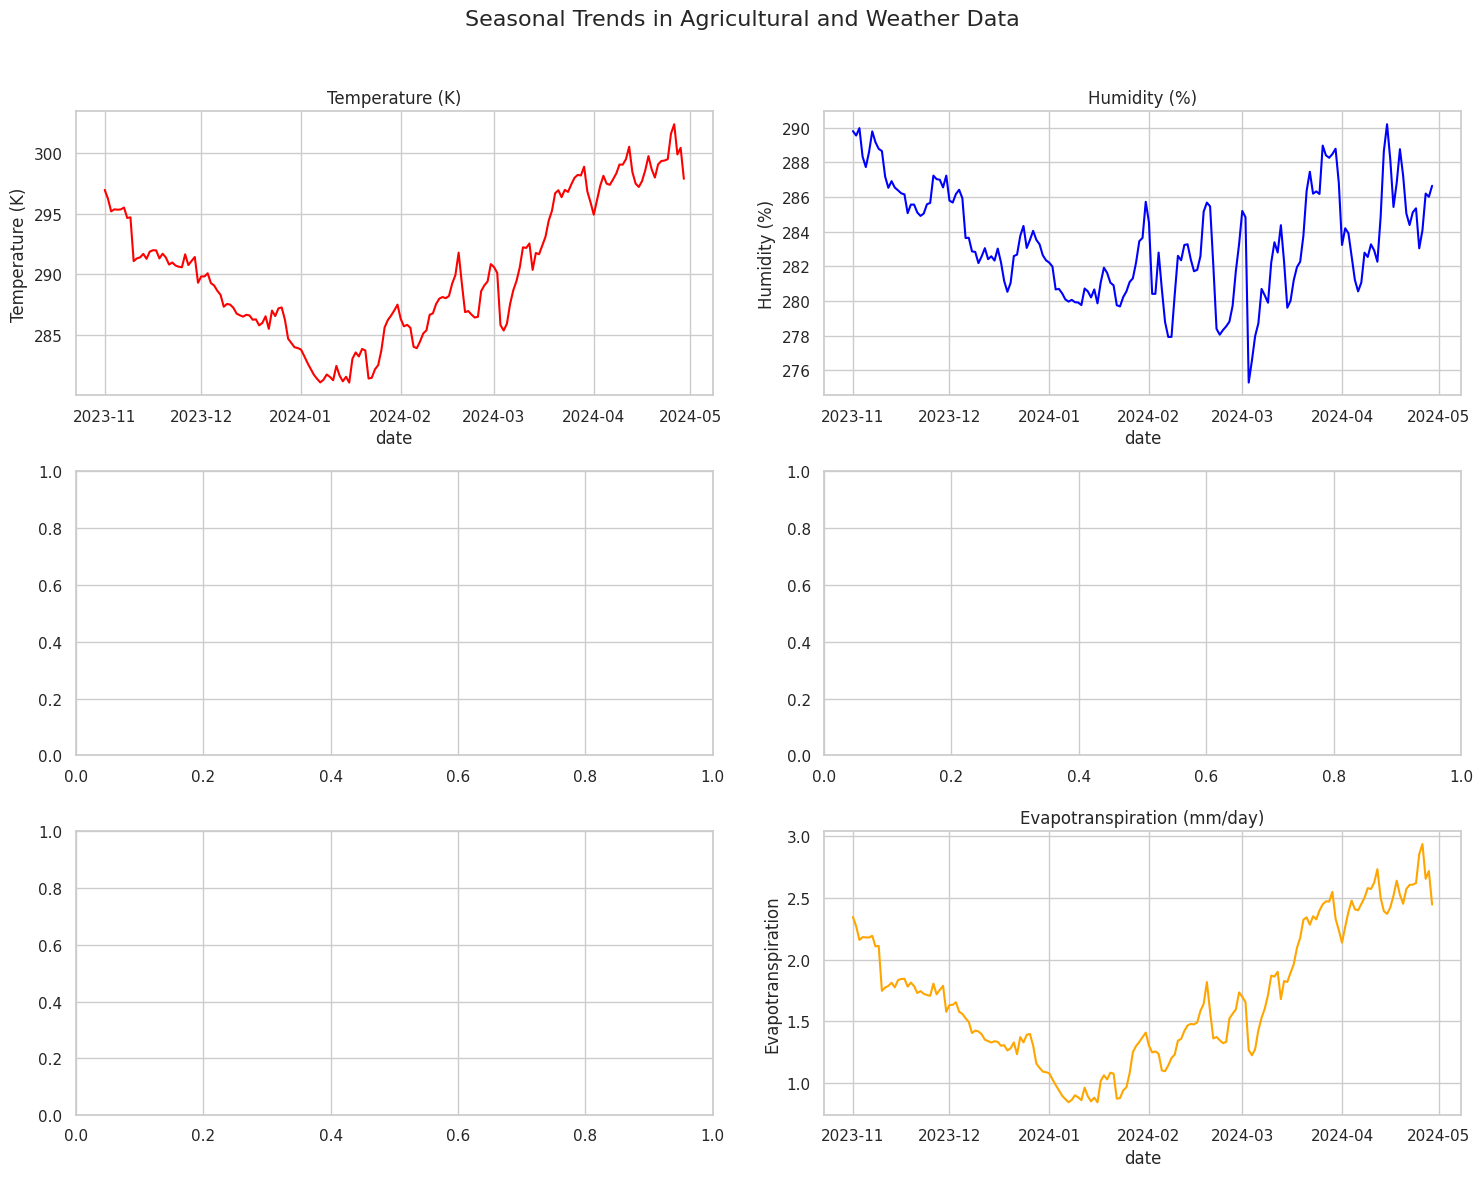

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
sns.set(style="whitegrid")

# Convert index to datetime if not already
data.index = pd.to_datetime(data.index)

# Define figure and axis
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle("Seasonal Trends in Agricultural and Weather Data", fontsize=16)

# 1. Temperature Trend
sns.lineplot(ax=axes[0, 0], data=data, x=data.index, y="temperature", color="red")
axes[0, 0].set_title("Temperature (K)")
axes[0, 0].set_ylabel("Temperature (K)")

# 2. Humidity Trend
sns.lineplot(ax=axes[0, 1], data=data, x=data.index, y="humidity", color="blue")
axes[0, 1].set_title("Humidity (%)")
axes[0, 1].set_ylabel("Humidity (%)")

# 3. Evapotranspiration Trend
sns.lineplot(ax=axes[2, 1], data=data, x=data.index, y="evapotranspiration", color="orange")
axes[2, 1].set_title("Evapotranspiration (mm/day)")
axes[2, 1].set_ylabel("Evapotranspiration")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




Missing Values:
 date                  0
humidity              0
temperature           0
evapotranspiration    0
dtype: int64

Duplicate Rows: 0


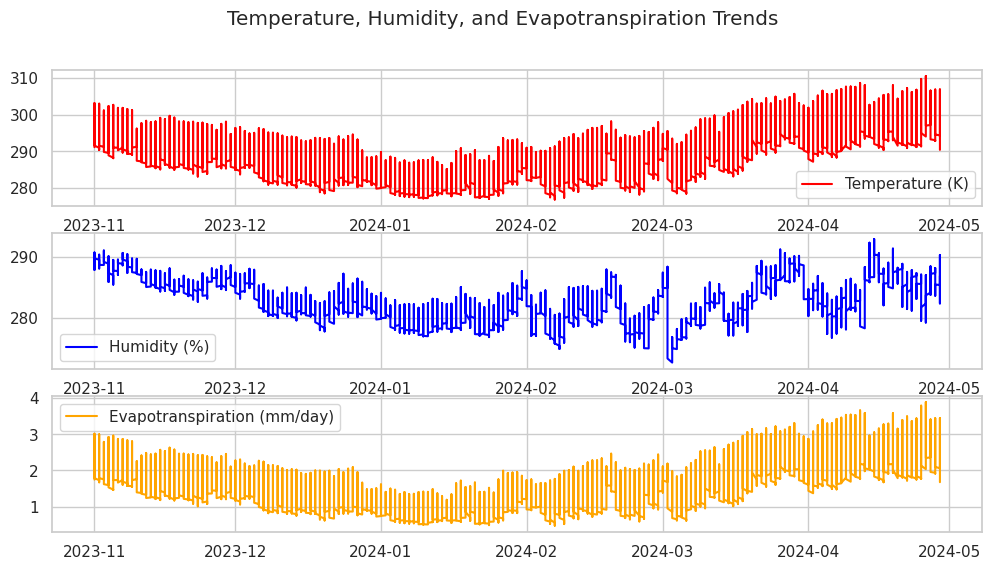

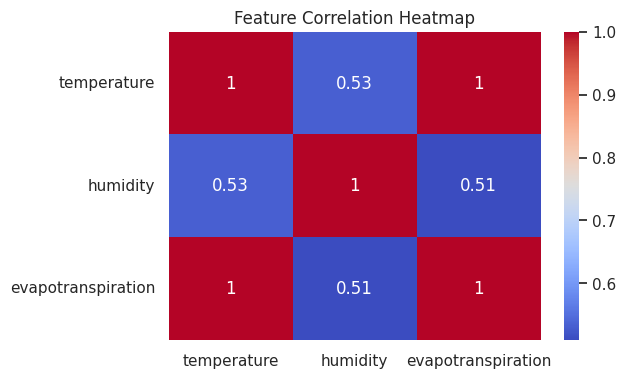

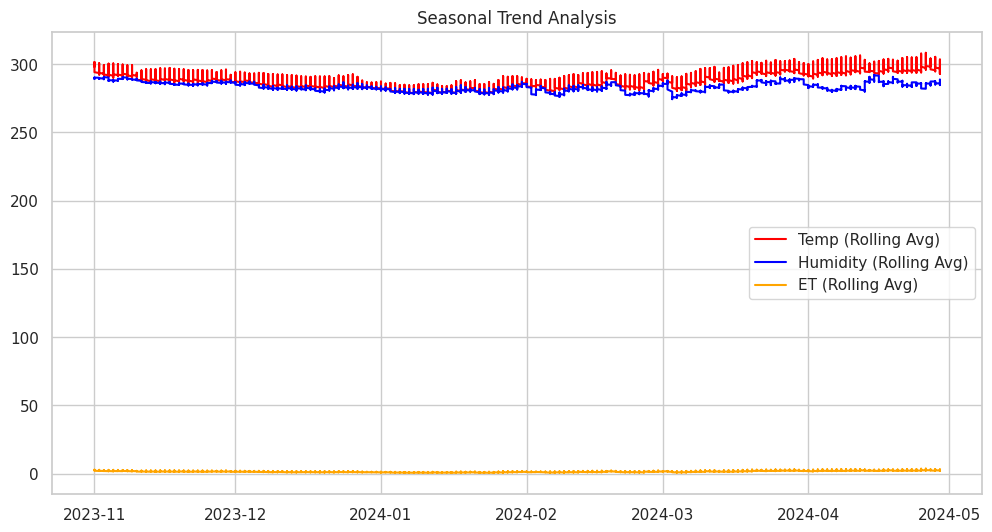

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
data = pd.read_csv('cleaned_punjab_wheat_data.csv', parse_dates=['date'])

# 1️⃣ Check for missing values & duplicates
print("Missing Values:\n", data.isnull().sum())
print("\nDuplicate Rows:", data.duplicated().sum())

# Drop duplicates if any
data.drop_duplicates(inplace=True)

# 2️⃣ Visualize trends
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['temperature'], color='red', label='Temperature (K)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['date'], data['humidity'], color='blue', label='Humidity (%)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['date'], data['evapotranspiration'], color='orange', label='Evapotranspiration (mm/day)')
plt.legend()

plt.suptitle("Temperature, Humidity, and Evapotranspiration Trends")
plt.show()

# 3️⃣ Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(data[['temperature', 'humidity', 'evapotranspiration']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# 4️⃣ Rolling Average for Seasonal Patterns
data['temp_rolling'] = data['temperature'].rolling(10).mean()
data['humidity_rolling'] = data['humidity'].rolling(10).mean()
data['evap_rolling'] = data['evapotranspiration'].rolling(10).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['temp_rolling'], label='Temp (Rolling Avg)', color='red')
plt.plot(data['date'], data['humidity_rolling'], label='Humidity (Rolling Avg)', color='blue')
plt.plot(data['date'], data['evap_rolling'], label='ET (Rolling Avg)', color='orange')
plt.legend()
plt.title("Seasonal Trend Analysis")
plt.show()

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('cleaned_punjab_wheat_data.csv', parse_dates=['date'], index_col='date')

# Keep only required columns
data = data[['temperature', 'humidity', 'evapotranspiration']]

# Handle missing values (fill with forward fill method)
data.fillna(method='ffill', inplace=True)

# Train-test split (2019-2023 for training, 2024 for testing)
train_data = data[:'2023']
test_data = data['2024':]

# Normalize for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convert time series data to sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Save prepared data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

print("Data preparation completed. Ready for model training!")


Data preparation completed. Ready for model training!


<ipython-input-76-b2986ec6447a>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [77]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
data = pd.read_csv('cleaned_punjab_wheat_data.csv', parse_dates=['date'], index_col='date')
data = data[['temperature', 'humidity', 'evapotranspiration']]

def preprocess_data(df, sequence_length=30):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    sequences, targets = [], []
    for i in range(len(df_scaled) - sequence_length):
        sequences.append(df_scaled[i:i+sequence_length])
        targets.append(df_scaled[i+sequence_length])

    return np.array(sequences), np.array(targets), scaler

sequence_length = 30  # Use past 30 days to predict next day
X, y, scaler = preprocess_data(data, sequence_length)

# Split into train and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 3)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(3)  # Predicting 3 values: Temperature, Humidity, Evapotranspiration
])

model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale predictions and actual values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}, MAE: {mae}, R²: {r2}')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


216/216 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.0341 - val_loss: 0.0084
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 10/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 11/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 12/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 24

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('cleaned_punjab_wheat_data.csv', parse_dates=['date'], index_col='date')
data = data[['temperature', 'humidity', 'evapotranspiration']].dropna()

# Feature Engineering - Creating lag features
data['temp_lag1'] = data['temperature'].shift(1)
data['humidity_lag1'] = data['humidity'].shift(1)
data['evapo_lag1'] = data['evapotranspiration'].shift(1)
data.dropna(inplace=True)

# Define Features & Target
X = data[['temperature', 'humidity', 'temp_lag1', 'humidity_lag1', 'evapo_lag1']]
y = data['evapotranspiration']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standard Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)
xgb_pred_scaled = xgb_model.predict(X_test_scaled)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled)
rf_pred_scaled = rf_model.predict(X_test_scaled)

# Convert Predictions Back to Original Scale
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).ravel()
rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n")
    return r2

xgb_r2 = evaluate_model(y_test, xgb_pred, "XGBoost")
rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")

# Choose Best Model
best_model = "XGBoost" if xgb_r2 > rf_r2 else "Random Forest"
print(f"Best Model: {best_model}")


XGBoost Performance:
RMSE: 0.1325, MAE: 0.0544, R²: 0.9459

Random Forest Performance:
RMSE: 0.1410, MAE: 0.0617, R²: 0.9387

Best Model: XGBoost


 ***Using LSTM for predicting Temerature and Humidity***

 ***Using XGBoost for predicting Evapotranspiration***

In [94]:
# Check shapes (remove the parentheses)
print("X_test shape:", X_test.shape)
print("Model input shape:", model.input_shape)

# Let's also see what our data looks like
print("\nFirst few values of X_test:")
print(X_test[:1])

X_test shape: (869, 5)
Model input shape: (None, 30, 3)

First few values of X_test:
            temperature    humidity   temp_lag1  humidity_lag1  evapo_lag1
date                                                                      
2024-03-24   292.931915  287.433044  293.357025     288.064835    1.964775


In [108]:
import numpy as np
import pandas as pd

def prepare_sequence_for_prediction(data, sequence_length=30):
    """
    Prepare the last sequence of data for prediction
    """
    # Select only the features used in training: temperature, humidity, evapotranspiration
    features = ['temperature', 'humidity', 'evapotranspiration']

    # Convert to numpy array if it's a DataFrame
    if isinstance(data, pd.DataFrame):
        data = data[features].values

    # Get the last sequence_length rows
    last_sequence = data[-sequence_length:]

    # Reshape to match model's input shape (1, sequence_length, n_features)
    last_sequence = last_sequence.reshape(1, sequence_length, len(features))

    return last_sequence

def predict_next_days(model, last_sequence, scaler, n_days=5):
    """
    Predict the next n_days using the model
    """
    current_sequence = last_sequence.copy()
    predictions = []

    for _ in range(n_days):
        # Predict next day
        next_day = model.predict(current_sequence, verbose=0)
        predictions.append(next_day[0])

        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, :] = next_day[0]

    # Convert predictions to original scale
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions)

    # Create DataFrame with predictions
    dates = pd.date_range(start=pd.Timestamp('2024-03-24') + pd.Timedelta(days=1),
                         periods=n_days, freq='D')

    pred_df = pd.DataFrame(predictions,
                          columns=['temperature', 'humidity', 'evapotranspiration'],
                          index=dates)

    return pred_df

# Prepare the last sequence
data_for_prediction = prepare_sequence_for_prediction(data, sequence_length=30)
print("Prepared sequence shape:", data_for_prediction.shape)

# Make predictions
predictions = predict_next_days(model, data_for_prediction, scaler, n_days=5)

# Display temperature and humidity predictions
print("\nPredictions for the next 5 days:")
print("\nTemperature predictions:")
print(predictions[['temperature']])
print("\nHumidity predictions:")
print(predictions[['humidity']])

# Calculate average predictions
avg_temp = predictions['temperature'].mean()
avg_humidity = predictions['humidity'].mean()

print(f"\nAverage predicted temperature: {avg_temp:.2f}")
print(f"Average predicted humidity: {avg_humidity:.2f}")

# Find max and min values
max_temp = predictions['temperature'].max()
min_temp = predictions['temperature'].min()
max_humidity = predictions['humidity'].max()
min_humidity = predictions['humidity'].min()

print(f"\nTemperature range: {min_temp:.2f} to {max_temp:.2f}")
print(f"Humidity range: {min_humidity:.2f} to {max_humidity:.2f}")

Prepared sequence shape: (1, 30, 3)

Predictions for the next 5 days:

Temperature predictions:
            temperature
2024-03-25   345.290863
2024-03-26   343.870300
2024-03-27   344.804810
2024-03-28   343.725098
2024-03-29   341.385773

Humidity predictions:
              humidity
2024-03-25  292.214630
2024-03-26  291.132446
2024-03-27  284.402863
2024-03-28  282.363434
2024-03-29  282.096436

Average predicted temperature: 343.82
Average predicted humidity: 286.44

Temperature range: 341.39 to 345.29
Humidity range: 282.10 to 292.21


In [111]:
predictions

,temperature,humidity,evapotranspiration
2024-03-25,345.290863,292.214630,7.777919
2024-03-26,343.870300,291.132446,7.619867
2024-03-27,344.804810,284.402863,7.650536
2024-03-28,343.725098,282.363434,7.503204
2024-03-29,341.385773,282.096436,7.252888


In [112]:
# Save predictions to a CSV file
predictions.to_csv("predicted_evapotranspiration.csv", index=True)
print("\nPredictions saved to 'predicted_temp&humid.csv'")


Predictions saved to 'predicted_temp&humid.csv'


In [114]:
import pandas as pd

def predict_next_days(model, last_data, n_days=10):
    """
    Predict evapotranspiration for the next n_days using the trained XGBoost model.
    """
    predictions = []
    current_data = last_data.copy()

    for _ in range(n_days):
        # Make prediction for current day
        pred = model.predict(current_data)[0]
        predictions.append(pred)

        # Update input features for the next day
        new_data = pd.DataFrame({
            'temperature': [current_data['temperature'].iloc[0]],  # Keep same temperature
            'humidity': [current_data['humidity'].iloc[0]],        # Keep same humidity
            'temp_lag1': [current_data['temperature'].iloc[0]],
            'humidity_lag1': [current_data['humidity'].iloc[0]],
            'evapo_lag1': [pred]  # Use predicted evapotranspiration as lag feature
        })

        # Ensure data type consistency
        current_data = new_data.astype(float)

    # Create future dates
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=n_days, freq='D')

    # Store results in DataFrame
    pred_df = pd.DataFrame({
        'evapotranspiration': predictions
    }, index=future_dates)

    return pred_df

# Get the last row as input data
last_date = data.index[-1]
last_data = data.loc[last_date].iloc[-1:].copy()  # Select only the last row
last_data = last_data[['temperature', 'humidity', 'temp_lag1', 'humidity_lag1', 'evapo_lag1']]

# Ensure correct format
last_data = last_data.astype(float)

# Predict next 10 days
predictions_eva = predict_next_days(xgb_model, last_data, n_days=5)

# Display predictions
print("\nPredicted evapotranspiration for the next 10 days:")
print(predictions_eva)



Predicted evapotranspiration for the next 10 days:
            evapotranspiration
2024-04-30            2.829058
2024-05-01            2.829058
2024-05-02            2.829058
2024-05-03            2.829058
2024-05-04            2.829058


In [116]:
predictions_eva

,evapotranspiration
2024-04-30,2.829058
2024-05-01,2.829058
2024-05-02,2.829058
2024-05-03,2.829058
2024-05-04,2.829058


In [117]:
# Save predictions to a CSV file
predictions_eva.to_csv("predicted_evapotranspiration.csv", index=True)
print("\nPredictions saved to 'predicted_evapotranspiration.csv'")



Predictions saved to 'predicted_evapotranspiration.csv'
